<a href="https://colab.research.google.com/github/lsoica/blog/blob/main/assets/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Forecast with an LSTM NN and PyTorch

## Install required packages

In [ ]:
!pip install yfinance scikit-learn


## Import libraries

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import yfinance as yf
import pandas as pd
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler

## Load the Amazon historical data fro YF

In [87]:
ticker = 'AMZN'
amazon_stock_data = yf.download(ticker, start="1997-05-20", end="2024-10-07")
amazon_stock_data.to_csv('AMZN.csv')
data = pd.read_csv('AMZN.csv')

[*********************100%***********************]  1 of 1 completed


In [88]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
2,1997-05-22,0.071875,0.072396,0.065625,0.069792,0.069792,235536000
3,1997-05-23,0.070313,0.076042,0.066667,0.075000,0.075000,318744000
4,1997-05-27,0.075521,0.082292,0.072917,0.079167,0.079167,173952000
...,...,...,...,...,...,...,...
6885,2024-09-30,187.139999,188.490005,184.649994,186.330002,186.330002,41583900
6886,2024-10-01,184.899994,186.190002,183.449997,185.130005,185.130005,36044900
6887,2024-10-02,184.440002,186.600006,184.039993,184.759995,184.759995,23704100
6888,2024-10-03,183.050003,183.440002,180.880005,181.960007,181.960007,30204300


In [89]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1997-05-20,0.081771
1,1997-05-21,0.071354
2,1997-05-22,0.069792
3,1997-05-23,0.075000
4,1997-05-27,0.079167
...,...,...
6885,2024-09-30,186.330002
6886,2024-10-01,185.130005
6887,2024-10-02,184.759995
6888,2024-10-03,181.960007


In [90]:
data['Date'] = pd.to_datetime(data['Date'])

/var/folders/59/c32_bthx48jd9m2ym5m3tnpw0000j7/T/ipykernel_36693/1453708669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


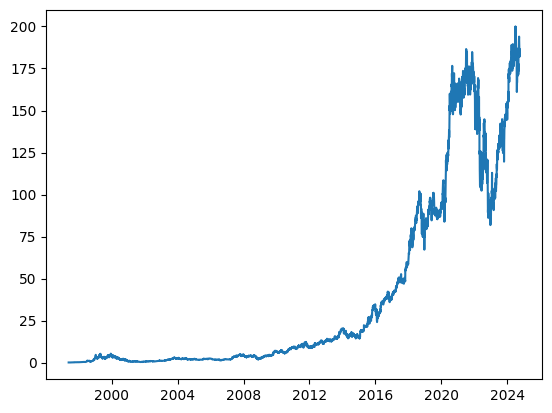

In [91]:
plt.plot(data['Date'], data['Close'])

In [92]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace = True)
    for i in range(1, n_steps + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace = True)
    return df

loopback = 7
shifted_df = prepare_dataframe_for_lstm(data, loopback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
1997-06-03,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792
1997-06-04,0.070833,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000
1997-06-05,0.077083,0.070833,0.073958,0.075521,0.075000,0.075260,0.076563,0.079167
...,...,...,...,...,...,...,...,...
2024-09-30,186.330002,187.970001,191.160004,192.529999,193.960007,193.880005,191.600006,189.869995
2024-10-01,185.130005,186.330002,187.970001,191.160004,192.529999,193.960007,193.880005,191.600006
2024-10-02,184.759995,185.130005,186.330002,187.970001,191.160004,192.529999,193.960007,193.880005


In [93]:
shifted_df_as_numpy = shifted_df.to_numpy()

In [94]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_numpy = scaler.fit_transform(shifted_df_as_numpy)

In [95]:
X = dc(np.flip(shifted_df_as_numpy[:, 1:], axis = 1))
y = shifted_df_as_numpy[:, 0]

In [96]:
x.shape, y.shape

((6883, 7), (6883,))

In [97]:
split_index = int(.95 * len(X))
split_index

6538

## Build train and test splits

In [98]:
X_train = X[: split_index]
X_test = X[split_index :]

y_train = y[: split_index]
y_test = y[split_index :]

X_train.shape , X_test.shape , y_train.shape , y_test.shape

((6538, 7), (345, 7), (6538,), (345,))

In [99]:
X_train = X_train.reshape((-1, loopback, 1))
X_test = X_test.reshape((-1, loopback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6538, 7, 1), (345, 7, 1), (6538, 1), (345, 1))

In [100]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()
X_train.shape , X_test.shape , y_train.shape , y_test.shape

(torch.Size([6538, 7, 1]),
 torch.Size([345, 7, 1]),
 torch.Size([6538, 1]),
 torch.Size([345, 1]))

## Built PyTorch DataSets and DataLoaders

In [101]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [102]:
from torch.utils.data import DataLoader

batchsize = 16

train_loader = DataLoader(train_dataset, batch_size = batchsize, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size  = len(X), shuffle  = False)

## Select the backend (MPS in my case for an M2)

In [103]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

## Define the NN model

In [104]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(1, 4, 1).to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

## Define the train and validate functions

In [105]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch {epoch+1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        output = model(x_batch)
        loss = loss_fn(output, y_batch)

        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, loss: {1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
            running_loss = 0.0
    print()

def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_fn(output, y_batch)

            running_loss += loss.item()
        
    avg_loss_across_batches = running_loss / len(test_loader)
    print('Val loss: {0:.3f}'.format(avg_loss_across_batches))
    print()


## Train the model

In [106]:
learning_rate = 0.001
num_epochs = 10
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch 1
Batch 100, loss: 0.397
Batch 200, loss: 0.143
Batch 300, loss: 0.048
Batch 400, loss: 0.015

Val loss: 0.131

Epoch 2
Batch 100, loss: 0.009
Batch 200, loss: 0.007
Batch 300, loss: 0.006
Batch 400, loss: 0.004

Val loss: 0.042

Epoch 3
Batch 100, loss: 0.003
Batch 200, loss: 0.002
Batch 300, loss: 0.001
Batch 400, loss: 0.001

Val loss: 0.018

Epoch 4
Batch 100, loss: 0.001
Batch 200, loss: 0.001
Batch 300, loss: 0.001
Batch 400, loss: 0.001

Val loss: 0.012

Epoch 5
Batch 100, loss: 0.001
Batch 200, loss: 0.001
Batch 300, loss: 0.001
Batch 400, loss: 0.001

Val loss: 0.010

Epoch 6
Batch 100, loss: 0.001
Batch 200, loss: 0.001
Batch 300, loss: 0.001
Batch 400, loss: 0.000

Val loss: 0.009

Epoch 7
Batch 100, loss: 0.001
Batch 200, loss: 0.001
Batch 300, loss: 0.001
Batch 400, loss: 0.000

Val loss: 0.007

Epoch 8
Batch 100, loss: 0.000
Batch 200, loss: 0.000
Batch 300, loss: 0.000
Batch 400, loss: 0.000

Val loss: 0.006

Epoch 9
Batch 100, loss: 0.000
Batch 200, loss: 0.000
Ba

## Plot real versus predicted

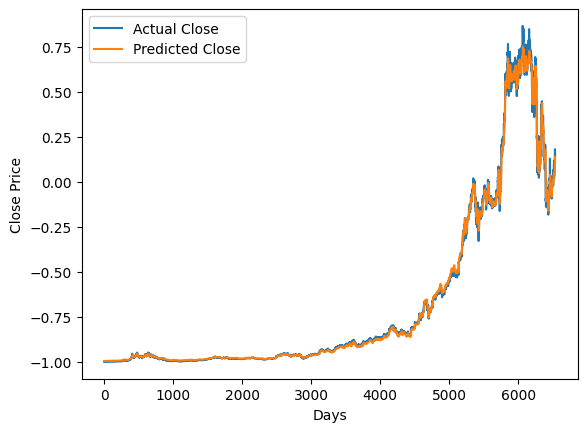

In [107]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()